In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [11]:
EJs=[21, 20, 22, 21.5]
ECs=[0.25, 0.3, 0.35, 0.2]
gs=[0.05, 0.05, 0.05]
cutoffs=[4,5,4,4]

EJ_sweep = np.linspace(15, 30, 31)
EC_sweep = np.linspace(0.1, 0.4, 31)


psi0s = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge']
psi0_to_psi_freqs = dict(
    eggg=dict(),
    gfgg=dict(),
    ggeg=dict(),
    eegg=dict(),
    ggge=dict(),
)

for EJ1 in EJ_sweep:
    qram = QSwitch(
        EJs=[EJ1, *EJs[1:]],
        ECs=ECs,
        gs=gs,
        cutoffs=cutoffs
    )
    for n_psi0, psi0 in enumerate(psi0s):
        psi0_ids = qram.level_name_to_nums(psi0)
        for i1 in range(cutoffs[0]):
            for i2 in range(cutoffs[1]):
                for i3 in range(cutoffs[2]):
                    for i4 in range(cutoffs[3]):
                        n_excite = np.abs(i1+i2+i3+i4-sum(psi0_ids))
                        if not 1 <= n_excite <= 2: continue
                        if n_excite == 1: # single photon transition with drive on 2nd qubit
                            if np.abs(i2-psi0_ids[1]) != 1: continue
                        elif n_excite == 2: # 2 photon transition with drive on 2nd qubit
                            if np.abs(i2-psi0_ids[1]) != 2: continue
                        psi = qram.level_nums_to_name([i1,i2,i3,i4])
                        if psi in psi0s[:n_psi0]: continue
                        if qram.get_Tpi(psi, psi0, 0.5) > 1000: continue # coupling too small to care
                        if not psi in psi0_to_psi_freqs[psi0]:
                            psi0_to_psi_freqs[psi0][psi] = []
                        
                        if n_excite == 1:
                            psi0_to_psi_freqs[psi0][psi].append(np.abs(qram.get_wd(psi0, psi))/2/np.pi)
                        else:
                            psi0_to_psi_freqs[psi0][psi].append(np.abs(0.5*qram.get_wd(psi0, psi))/2/np.pi)

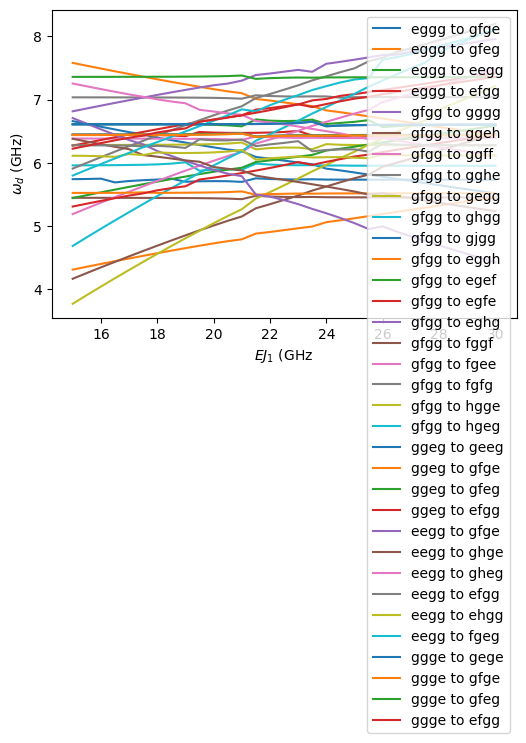

In [12]:
# for psi0 in ['eggg']:
for psi0 in psi0s:
    for psi, freqs in psi0_to_psi_freqs[psi0].items():
        if len(freqs) != len(EJ_sweep): continue
        plt.plot(EJ_sweep, freqs, label=f'{psi0} to {psi}')
plt.xlabel(r'$EJ_1$ (GHz')
plt.ylabel(r'$\omega_d$ (GHz)')
plt.legend()
plt.show()

are transitions like eggg to gfge allowed?